# Copyright Netherlands eScience Center <br>
** Function     : Lead/Lag regression of climatological fields with spatial patterns in certain seasons** <br>
** Author       : Yang Liu ** <br>
** First Built  : 2018.09.12 ** <br>
** Last Update  : 2018.09.12 ** <br>
Description     : This notebook includes the result of the lag regression of climatological fields (e.g. SST, SLP, z500). It aims to unveil the relation between the climatological fields and try to illustrate how the atmosphere responses to the change of ocean.
Return Values   : jpeg <br>

In [8]:
%matplotlib inline

import sys
sys.path.append("/home/yang/NLeSC/Computation_Modeling/Bjerknes/Scripts/META")
import numpy as np
import scipy
from netCDF4 import Dataset
import matplotlib
import matplotlib.pyplot as plt
import os
import meta.statistics
import meta.visualizer

import matplotlib
import seaborn as sns
import matplotlib.path as mpath
import matplotlib.ticker as mticker
import iris
import iris.plot as iplt
import iris.quickplot as qplt
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

Initialization - Start with location of input and extraction of variables
Time span of each product:
- **ERA-Interim** 1979 - 2016
- **MERRA2**      1980 - 2016
- **JRA55**       1979 - 2015
- **ORAS4**       1958 - 2014
- **GLORYS2V3**   1993 - 2014
- **SODA3**       1980 - 2015

In [2]:
# constants
constant = {'g' : 9.80616,      # gravititional acceleration [m / s2]
            'R' : 6371009,      # radius of the earth [m]
            'cp': 1004.64,      # heat capacity of air [J/(Kg*K)]
            'Lv': 2264670,      # Latent heat of vaporization [J/Kg]
            'R_dry' : 286.9,    # gas constant of dry air [J/(kg*K)]
            'R_vap' : 461.5,    # gas constant for water vapour [J/(kg*K)]
            }

In [52]:
if __name__=="__main__":
    # sample
    ################################   Input zone  ######################################
    # specify data path
    datapath = '/home/yang/workbench/Core_Database_AMET_OMET_reanalysis/warehouse_met'
    datapath_ERAI_fields = '/home/yang/workbench/Core_Database_AMET_OMET_reanalysis/ERAI/regression'
    output_path = '/home/yang/NLeSC/Computation_Modeling/Bjerknes/Compensation/MET_leadlag/MCA/fields_only'
    #####################################################################################
    print ('*********************** extract variables *************************')
    dataset_ERAI_fields_SIC_SST_SLP = Dataset(os.path.join(datapath_ERAI_fields,
                                              'surface_ERAI_monthly_regress_1979_2016.nc'))
    dataset_ERAI_fields_SFlux = Dataset(os.path.join(datapath_ERAI_fields,
                                                     'surface_ERAI_monthly_regress_1979_2016_extra.nc'))
    dataset_ERAI_500hPa = Dataset(os.path.join(datapath_ERAI_fields,
                                               'pressure_500hPa_ERAI_monthly_regress_1979_2016.nc'))
    dataset_ERAI_AMET = Dataset(os.path.join(datapath,
                                             'era_model_subdaily_1979_2016_amet.nc'))
    dataset_ERAI_fields_flux = Dataset(os.path.join(datapath_ERAI_fields,
                                                    'surface_erai_monthly_regress_1979_2017_radiation.nc'))
    # extract time series from 1979 to 2016
    # from 20N - 90N
    # 4D fields [year, month, lat, lon]
    # geopotential height at 500hPa (m)
    z_500hPa_ERAI = dataset_ERAI_500hPa.variables['z'][:] / constant['g']
    # 3D fields [time, lat, lon]
    SST_ERAI = dataset_ERAI_fields_SIC_SST_SLP.variables['sst'][:]
    SST_ERAI_mask = np.ma.getmaskarray(SST_ERAI[0,:,:])
    # other dimensions
    year_ERAI = dataset_ERAI_AMET.variables['year']
    latitude_fields_ERAI = dataset_ERAI_fields_SIC_SST_SLP.variables['latitude'][:]
    longitude_fields_ERAI = dataset_ERAI_fields_SIC_SST_SLP.variables['longitude'][:]
    #size of the grid box
    dx = 2 * np.pi * constant['R'] * np.cos(2 * np.pi * latitude_fields_ERAI /
                                            360) / len(longitude_fields_ERAI) 
    dy = np.pi * constant['R'] / len(latitude_fields_ERAI)
    # include latitude weight
    SST_ERAI_weight = np.zeros(SST_ERAI.shape, dtype=float)
    z_500hPa_ERAI_weight = np.zeros(z_500hPa_ERAI.shape, dtype=float)
    for i in np.arange(len(latitude_fields_ERAI)):
        SST_ERAI_weight[:,i,:] = SST_ERAI[:,i,:] * dx[i] / dx[94]
        z_500hPa_ERAI_weight[:,:,i,:] = z_500hPa_ERAI[:,:,i,:] * dx[i] / dx[94]

*********************** extract variables *************************


In [4]:
    # take variables at specific locations
    nt = len(year_ERAI) * 12
    # SST 20N - 80N : 90W - 20E
    lon_SST_sel = np.zeros(148, dtype=float)
    lon_SST_sel[0:120] = longitude_fields_ERAI[360:] - 360
    lon_SST_sel[120:] = longitude_fields_ERAI[:28]
    lat_SST_sel = latitude_fields_ERAI[13:95]
    SST_sel = np.zeros((nt,len(lat_SST_sel), len(lon_SST_sel)), dtype=float)
    SST_sel[:,:,0:120] = SST_ERAI_weight[:,13:95,360:]
    SST_sel[:,:,120:] = SST_ERAI_weight[:,13:95,:28]
    # z500 20N - 80N : 90W - 40E
    lon_z500_sel = np.zeros(175, dtype=float)
    lon_z500_sel[0:120] = longitude_fields_ERAI[360:] - 360
    lon_z500_sel[120:] = longitude_fields_ERAI[:55]
    lat_z500_sel = latitude_fields_ERAI[13:95]
    z500_sel = np.zeros((len(year_ERAI),12,len(lat_z500_sel), len(lon_z500_sel)),
                       dtype=float)
    z500_sel[:,:,:,0:120] = z_500hPa_ERAI_weight[:,:,13:95,360:]
    z500_sel[:,:,:,120:] = z_500hPa_ERAI_weight[:,:,13:95,:55]
    # save memory
    del SST_ERAI, SST_ERAI_weight, z_500hPa_ERAI, z_500hPa_ERAI_weight

Table for an easy lead / lag analysis of seasonal data <br>

| -6 | -5 | -4 | -3 | -2 | -1 |winter| +1 | +2 | +3 | +4 | +5 | +6 |
|----|----|----|----|----|----|------|----|----|----|----|----|----|
|JJA |JAS |ASO |SON |OND |NDJ |DJF   |JFM |FMA |MAM |AMJ |MJJ |JJA |

| -6 | -5 | -4 | -3 | -2 | -1 |summer| +1 | +2 | +3 | +4 | +5 | +6 |
|----|----|----|----|----|----|------|----|----|----|----|----|----|
|DJF |JFM |FMA |MAM |AMJ |MJJ |JJA   |JAS |ASO |SON |OND |NDJ |DJF |

In [4]:
    # simple calculator for seasonal lead/lag pairing
    lag_winter = ['DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ',
                  'JJA', 'JAS', 'ASO', 'SON', 'OND', 'NDJ']
    lag_summer = ['JJA', 'JAS', 'ASO', 'SON', 'OND', 'NDJ',
                  'DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ']

Be cautious about the time across the year! <br>
winter (DJF) lag -1 : x[2:] & y[1:-1]<br>
winter (DJF) lag -2 : x[2:] & y[:-2]<br>
winter (DJF) lag -3 : x[2:] & y[:-2]<br>
...<br>
winter (DJF) lag +1 : x[2:] & y[:-2]<br>
... <br>
summer (JJA) lag -1 : x & y <br>
... <br>
summer (JJA) lag -6 : x[3:] & y[2:-1] <br>
summer (JJA) lag +1 : x & y <br>
... <br>
summer (JJA) lag +6 : x[:-1] & y[1:] <br>

Be cautious about the time across the year! <br>
winter (DJF) lag -1 : x[2:] & y[1:-1]<br>
winter (DJF) lag -2 : x[2:] & y[:-2]<br>
winter (DJF) lag -3 : x[2:] & y[:-2]<br>
...<br>
winter (DJF) lag +1 : x[2:] & y[:-2]<br>
... <br>
summer (JJA) lag -1 : x & y <br>
... <br>
summer (JJA) lag -6 : x[3:] & y[2:-1] <br>
summer (JJA) lag +1 : x & y <br>
... <br>
summer (JJA) lag +6 : x[:-1] & y[1:] <br>

In [5]:
    print ('*******************  postprocess with statistical tool  *********************')
    print ('***********!@#$%^&* MCA analysis of fields from ERA-Interim !@#$%^&**********')
    print ('======================   SST & z500  ======================')
    # prepare datasets -> removing seasonal cycling -> detrend -> smooth data
    # SST 20N - 80N : 90W - 20E
    SST_season_series = meta.statistics.operator.seasons(SST_sel[:],
                                                         span='MAM')
    stat_SST_ERAI = meta.statistics.operator(SST_season_series)
    stat_SST_ERAI.anomaly(Dim_month=False)
    stat_SST_ERAI.detrend()
    stat_SST_ERAI.lowpass(window=3, obj='detrend')
    # z500 20N - 80N : 90W - 40E
    z500_season_series = meta.statistics.operator.seasons(z500_sel[:],
                                                         span='JJA', Dim_month=True)
    stat_z500_ERAI = meta.statistics.operator(z500_season_series)
    stat_z500_ERAI.anomaly(Dim_month=False)
    stat_z500_ERAI.detrend()
    stat_z500_ERAI.lowpass(window=3, obj='detrend')
    # take the dimensions of input fields
    nt_SST, ny_SST, nx_SST = stat_SST_ERAI._lowpass.shape
    nt_z500, ny_z500, nx_z500 = stat_z500_ERAI._lowpass.shape
    # reshape the matrix
    stat_SST_ERAI_2D = np.reshape(stat_SST_ERAI._lowpass,[nt_SST,ny_SST*nx_SST], order='F')
    stat_z500_ERAI_2D = np.reshape(stat_z500_ERAI._lowpass,[nt_z500,ny_z500*nx_z500], order='F')
    # calculate covariance matrix -> keep the spatial dimension
    covariance_SST_z500 = np.dot(stat_SST_ERAI_2D.T, stat_z500_ERAI_2D) / (nt-1)
    # apply the SVD
    U, sigma, V = np.linalg.svd(covariance_SST_z500, full_matrices=False,
                                compute_uv = True)
    # sklearn.decomposition.TruncatedSVD (alternative)
    sigma_diag = np.diag(sigma)
    # Take the 1st mode of left pattern and right pattern and plot
    MCA_series_SST = np.dot(stat_SST_ERAI_2D, U[:,0])
    MCA_left_pattern_SST = U[:,0] * np.std(MCA_series_SST)
    
    MCA_series_z500 = np.dot(stat_z500_ERAI_2D, V[0,:].T)
    MCA_right_pattern_z500 = V[0,:] * np.std(MCA_series_z500)
    
    # reshape U and V matrix
    MCA_left_pattern_SST = np.reshape(MCA_left_pattern_SST, 
                                      [ny_SST, nx_SST], order='F')
    MCA_right_pattern_z500 = np.reshape(MCA_right_pattern_z500,
                                        [ny_z500, nx_z500], order='F')

*******************  postprocess with statistical tool  *********************
***********!@#$%^&* MCA analysis of fields from ERA-Interim !@#$%^&**********
======================   SST & z500  ======================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!


In [58]:
    MCA_series_SST = np.dot(stat_SST_ERAI_2D, U[:,0])
    MCA_left_pattern_SST = U[:,0] * np.std(MCA_series_SST)
    
    MCA_series_z500 = np.dot(stat_z500_ERAI_2D, V[0,:].T)
    MCA_right_pattern_z500 = V[0,:] * np.std(MCA_series_z500)
    
    # reshape U and V matrix
    MCA_left_pattern_SST = np.reshape(MCA_left_pattern_SST, 
                                      [ny_SST, nx_SST], order='F')
    MCA_right_pattern_z500 = np.reshape(MCA_right_pattern_z500,
                                        [ny_z500, nx_z500], order='F')

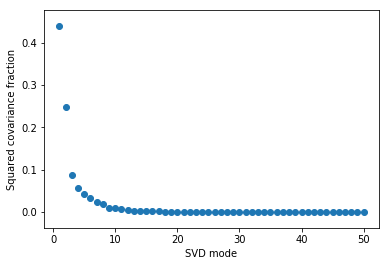

In [53]:
    # make plots for the fraction of squared covariance explained
    # It tells how much squared covariance is expalined by each mode
    sc = sigma**2 / np.sum(sigma**2)
    fig0 = plt.figure()
    plt.scatter(np.arange(1,len(sc[:50])+1,1),sc[:50])
    plt.xlabel('SVD mode')
    plt.ylabel('Squared covariance fraction')
    plt.show()
    fig0.savefig(os.path.join(output_path,'sst_z500', 'season',
                             'MCA_SC_ERAI_SST_lag_-3_ERAI_z500_JJA.png'), dpi=300)

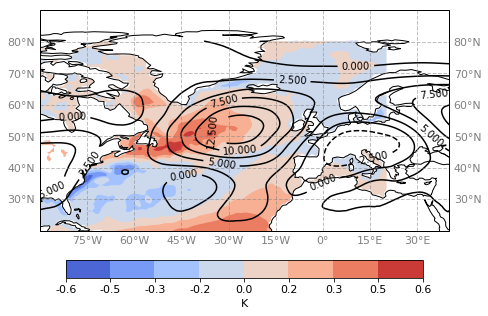

In [59]:
    # get the mask for SST
    SST_sel_mask = np.zeros((len(lat_SST_sel), len(lon_SST_sel)))
    SST_sel_mask[:,0:120] = SST_ERAI_mask[13:95,360:]
    SST_sel_mask[:,120:] = SST_ERAI_mask[13:95,:28]
    # make iris cube
    # MCA-SST
    lat_iris_SST = iris.coords.DimCoord(lat_SST_sel, standard_name='latitude', long_name='latitude',
                                        var_name='lat', units='degrees')
    lon_iris_SST = iris.coords.DimCoord(lon_SST_sel, standard_name='longitude', long_name='longitude',
                                        var_name='lon', units='degrees')
    cube_iris_SST = iris.cube.Cube(np.ma.masked_where(SST_sel_mask,-MCA_left_pattern_SST), 
                                   long_name='mca SST', var_name='sst', units='K',
                                   dim_coords_and_dims=[(lat_iris_SST, 0), (lon_iris_SST, 1)])
    # MCA-z500
    lat_iris_z500 = iris.coords.DimCoord(lat_z500_sel, standard_name='latitude', long_name='latitude',
                                        var_name='lat', units='degrees')
    lon_iris_z500 = iris.coords.DimCoord(lon_z500_sel, standard_name='longitude', long_name='longitude',
                                        var_name='lon', units='degrees')
    cube_iris_z500 = iris.cube.Cube(-MCA_right_pattern_z500, 
                                   long_name='mca z500', var_name='z500', units='m',
                                   dim_coords_and_dims=[(lat_iris_z500, 0), (lon_iris_z500, 1)])
    fig = plt.figure(figsize=(8,5.4))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-90,40,20,90],ccrs.PlateCarree())
    ax.set_aspect('1')
    ax.coastlines()
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 11, 'color': 'gray'}
    gl.ylabel_style = {'size': 11, 'color': 'gray'}
    cs = iplt.contourf(cube_iris_SST,cmap='coolwarm')
    cbar = fig.colorbar(cs,extend='both',orientation='horizontal',shrink =0.8,pad=0.1,format="%.1f")
    cbar.ax.tick_params(labelsize = 11)
    cbar.set_label('K',size = 11)
    contour = iplt.contour(cube_iris_z500, colors='k')
    plt.clabel(contour, inline=True)
    iplt.show()
    fig.savefig(os.path.join(output_path,'sst_z500', 'season',
                             'MCA_1st_ERAI_SST_lag_-3_ERAI_z500_JJA.png'), dpi=300)